In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from tqdm import tqdm

from wavenet import model, train, sample, audio, datasets, utils, viz

# Train on Tiny

A full training run with the big model, against tiny. Should crush it. 

In [3]:
dry = True 
if dry: os.environ['WANDB_MODE'] = 'disabled'

In [4]:
n_samples, n_examples = 30, 5_000
p = model.HParams(
    mixed_precision=False,
    n_audio_chans=1, 
    n_classes=2*n_samples, 
    n_chans=32,
    dilation_stacks=1,
    n_layers=6,
    compress=False, 
    sample_length=n_samples,
    seed=131,
    verbose=False
)

In [5]:
utils.seed(p)
ds, ds_test = datasets.Tiny(n_samples, n_examples), datasets.Tiny(n_samples, n_examples)
X, Y = datasets.to_tensor(ds)

In [6]:
m = model.Wavenet(p)
tp =  train.HParams(
    max_epochs=40, 
    batch_size=64, 
    num_workers=1, 
    learning_rate=0.01
)

t = train.Trainer(m, ds, ds_test, tp)
t.train()

  0%|          | 0/79 [00:00<?, ?it/s]/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/modules/module.py:785: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different auto

## Sample

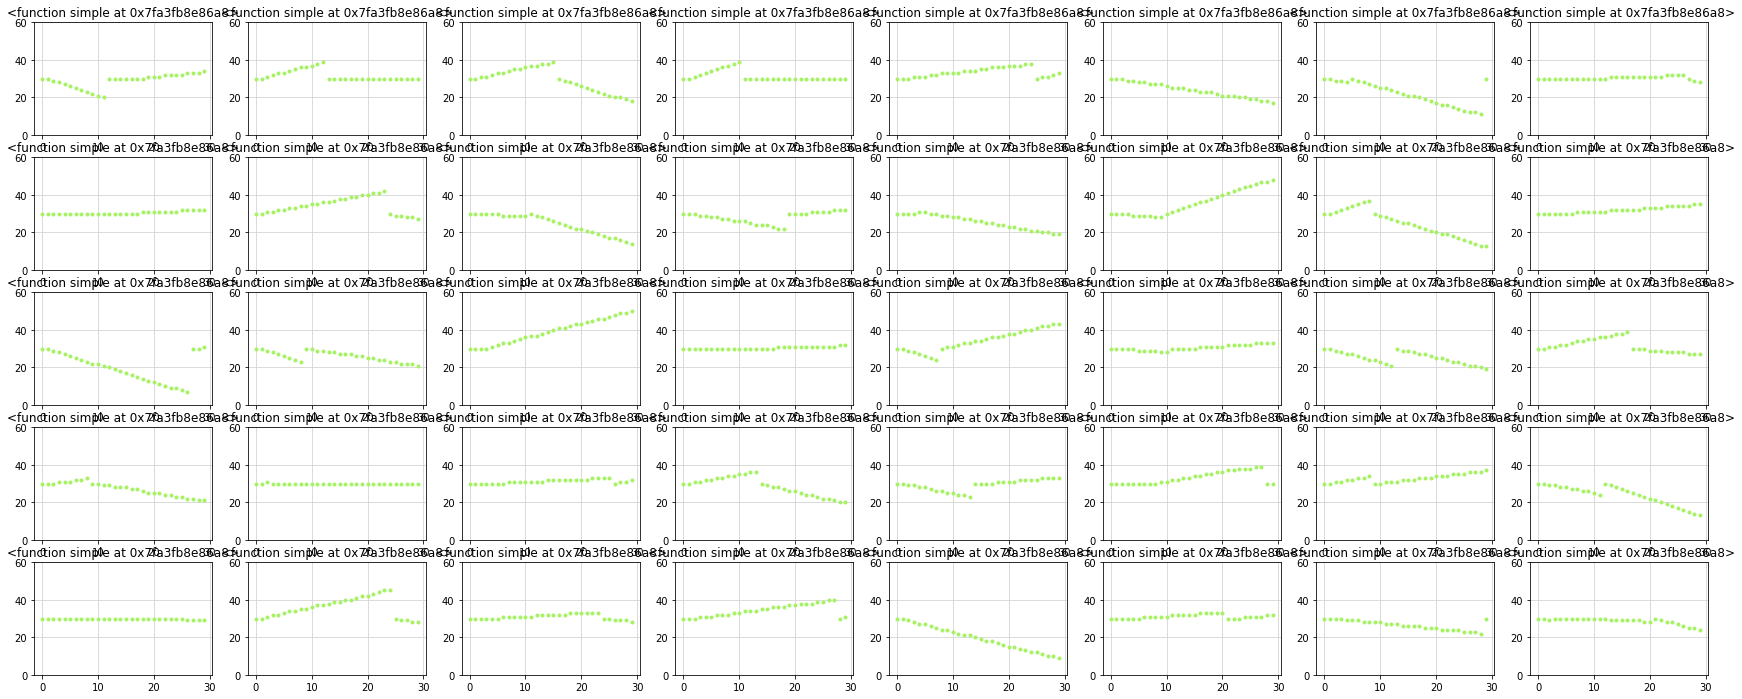

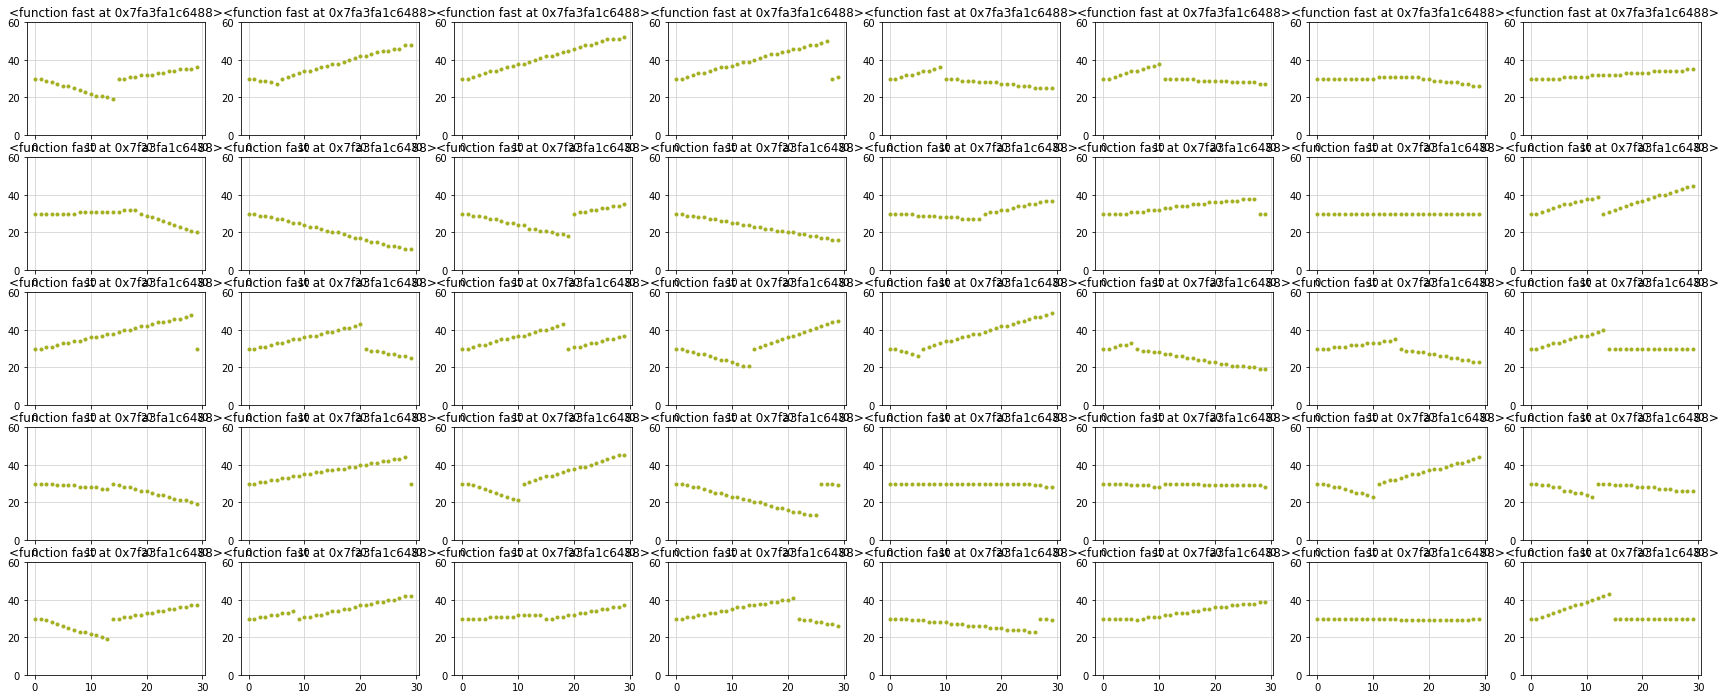

In [7]:
n_samples=30
batch_size=40

def plotit(generated, name):
    color = np.random.rand(3,)
    plt.subplots(figsize=(30, 12))
    for i in range(batch_size):
        plt.subplot(5, 8, i+1)
        plt.ylim(0, p.n_classes)
        plt.grid(color='lightgray')
        plt.title(name)
        plt.plot(torch.arange(n_samples), generated[i, 0], '.', color=color)


for f in [sample.simple, sample.fast]:
    y, logits, *_ = f(m, ds.transforms, utils.decode_random, n_samples=n_samples, batch_size=batch_size)
    plotit(y, str(f))